# Feature Importance in Random Forest & Decision Trees 🌟

## Core Concept 🎯

**Feature Importance** measures how much each feature contributes to decreasing node impurity across all trees in the forest. It answers: *"Which features are most useful for making accurate predictions?"*

> *"Not all features are created equal - some carry more predictive power!"*

---

## Types of Feature Importance 📊

### 1. **Gini Importance (Mean Decrease Impurity)** 
- **Default in scikit-learn**
- Based on impurity reduction during splits
- Fast to compute (calculated during training)

### 2. **Permutation Importance**
- Based on prediction performance degradation
- More reliable but computationally expensive
- Available post-training

### 3. **Drop Column Importance**
- Based on model performance without feature
- Most interpretable but very expensive

---

## Gini Importance (Mean Decrease Impurity) 📈

### Mathematical Foundation

For a **single decision tree**, feature importance is calculated as:

$$\text{Importance}_j^{\text{tree}} = \sum_{t \in T_j} p(t) \cdot \Delta I(t, j)$$

Where:
- $T_j$ = set of all nodes in the tree that split on feature $j$
- $p(t)$ = fraction of samples reaching node $t$
- $\Delta I(t, j)$ = impurity decrease when splitting node $t$ on feature $j$

### Impurity Decrease Calculation

$$\Delta I(t, j) = I(t) - \frac{|S_L|}{|S|} I(S_L) - \frac{|S_R|}{|S|} I(S_R)$$

Where:
- $I(t)$ = impurity of parent node $t$
- $S_L, S_R$ = left and right child samples after split
- $|S|$ = total samples in parent node

### Node Weight (Sample Fraction)

$$p(t) = \frac{\text{number of samples reaching node } t}{\text{total training samples}}$$

### Impurity Measures

**Classification (Gini)**:
$$I_{\text{Gini}}(t) = 1 - \sum_{c=1}^{C} p_c^2(t)$$

**Classification (Entropy)**:
$$I_{\text{Entropy}}(t) = -\sum_{c=1}^{C} p_c(t) \log_2 p_c(t)$$

**Regression (MSE)**:
$$I_{\text{MSE}}(t) = \frac{1}{|S|} \sum_{i \in S} (y_i - \bar{y}_t)^2$$

---

## Random Forest Feature Importance 🌲

### Aggregation Across Trees

For a **Random Forest** with $B$ trees:

$$\text{Importance}_j^{\text{RF}} = \frac{1}{B} \sum_{b=1}^{B} \text{Importance}_j^{\text{tree}_b}$$

### Normalization

Final importances are normalized to sum to 1:

$$\text{Normalized Importance}_j = \frac{\text{Importance}_j^{\text{RF}}}{\sum_{k=1}^{p} \text{Importance}_k^{\text{RF}}}$$

Where $p$ is the total number of features.

---

## Step-by-Step Calculation Example 📝

### Simple Decision Tree Example

Consider a binary classification tree:

```
Root Node (100 samples, Gini = 0.5)
├── Feature A ≤ 5: Left (60 samples, Gini = 0.3)
└── Feature A > 5: Right (40 samples, Gini = 0.4)
```

**Calculation for Feature A**:

1. **Parent Impurity**: $I(\text{root}) = 0.5$
2. **Weighted Child Impurity**: $\frac{60}{100} \times 0.3 + \frac{40}{100} \times 0.4 = 0.34$
3. **Impurity Decrease**: $\Delta I = 0.5 - 0.34 = 0.16$
4. **Node Weight**: $p(\text{root}) = \frac{100}{100} = 1.0$
5. **Feature Importance**: $1.0 \times 0.16 = 0.16$

### Multi-Level Tree

```
Root (1000 samples, Gini = 0.48)
├── A ≤ 10 (600 samples, Gini = 0.32)
│   ├── B ≤ 5 (400 samples, Gini = 0.24)
│   └── B > 5 (200 samples, Gini = 0.40)
└── A > 10 (400 samples, Gini = 0.35)
    ├── C ≤ 2 (300 samples, Gini = 0.20)
    └── C > 2 (100 samples, Gini = 0.30)
```

**Feature A Importance**:
- Node weight: $p = 1.0$
- Impurity decrease: $0.48 - (0.6 \times 0.32 + 0.4 \times 0.35) = 0.048$
- Contribution: $1.0 \times 0.048 = 0.048$

**Feature B Importance**:
- Node weight: $p = 0.6$ (600/1000 samples reach this node)
- Impurity decrease: $0.32 - (0.67 \times 0.24 + 0.33 \times 0.40) = 0.028$
- Contribution: $0.6 \times 0.028 = 0.0168$

---

## Implementation Details 💻

### Scikit-learn Code

```python
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Access feature importances
importances = rf.feature_importances_
feature_names = ['Feature_A', 'Feature_B', 'Feature_C']

# Create importance DataFrame
import pandas as pd
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)
```

### Manual Calculation (Single Tree)

```python
def calculate_feature_importance(tree, X, feature_names):
    """Calculate feature importance for a single decision tree"""
    
    # Get tree structure
    left_children = tree.tree_.children_left
    right_children = tree.tree_.children_right
    features = tree.tree_.feature
    thresholds = tree.tree_.threshold
    impurities = tree.tree_.impurity
    n_samples = tree.tree_.n_node_samples
    
    total_samples = n_samples[0]
    importances = np.zeros(len(feature_names))
    
    # Traverse all nodes
    for node_id in range(len(features)):
        if features[node_id] != -2:  # Not a leaf node
            
            # Calculate node weight
            node_weight = n_samples[node_id] / total_samples
            
            # Calculate impurity decrease
            left_impurity = impurities[left_children[node_id]]
            right_impurity = impurities[right_children[node_id]]
            left_samples = n_samples[left_children[node_id]]
            right_samples = n_samples[right_children[node_id]]
            
            weighted_impurity = (left_samples * left_impurity + 
                               right_samples * right_impurity) / n_samples[node_id]
            
            impurity_decrease = impurities[node_id] - weighted_impurity
            
            # Add to feature importance
            feature_idx = features[node_id]
            importances[feature_idx] += node_weight * impurity_decrease
    
    # Normalize
    importances = importances / np.sum(importances)
    
    return importances
```

---

## Permutation Importance 🔄

### Concept

**Permutation Importance** measures how much model performance **drops** when a feature's values are randomly shuffled.

### Mathematical Definition

$$\text{Permutation Importance}_j = \text{Score}_{\text{original}} - \text{Score}_{\text{permuted}_j}$$

Where:
- $\text{Score}_{\text{original}}$ = model performance on original data
- $\text{Score}_{\text{permuted}_j}$ = model performance when feature $j$ is shuffled

### Algorithm Steps

1. **Baseline**: Calculate model performance on original data
2. **Shuffle**: Randomly permute values of feature $j$
3. **Predict**: Make predictions with shuffled feature
4. **Compare**: Calculate performance drop
5. **Repeat**: Do this for all features

### Implementation

```python
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    rf, X_test, y_test, 
    n_repeats=10,          # Number of shuffles
    random_state=42,
    scoring='accuracy'     # or 'r2', 'neg_mean_squared_error', etc.
)

# Access results
importances_mean = perm_importance.importances_mean
importances_std = perm_importance.importances_std
```

---

## Comparison: Gini vs Permutation vs Drop Column 📊

| Method | Computation Time | Reliability | Interpretability | When to Use |
|--------|------------------|-------------|------------------|-------------|
| **Gini** | ⚡ Fast (free) | ⚠️ Can be biased | 📊 Moderate | Quick analysis, feature screening |
| **Permutation** | 🐌 Moderate | ✅ More reliable | 📈 High | Final feature importance, model interpretation |
| **Drop Column** | 🐌🐌 Slow | ✅ Most reliable | 🎯 Highest | Critical decisions, feature selection |

### Gini Importance Biases

1. **Cardinality Bias**: Favors features with more unique values
2. **Scale Bias**: May favor continuous over categorical features  
3. **Correlation Bias**: May underestimate correlated features

### Mathematical Relationship

$$\text{Gini Importance} \propto \text{Tree Usage} \times \text{Impurity Reduction}$$
$$\text{Permutation Importance} \propto \text{Performance Degradation}$$

---

## Advanced Techniques 🚀

### 1. **Conditional Feature Importance**

For correlated features, calculate importance **conditional** on other features:

```python
from sklearn.inspection import permutation_importance

def conditional_importance(model, X, y, feature_groups):
    """Calculate importance within feature groups"""
    importances = {}
    
    for group_name, features in feature_groups.items():
        # Permute entire group together
        X_permuted = X.copy()
        for feature in features:
            X_permuted[feature] = np.random.permutation(X_permuted[feature])
        
        original_score = model.score(X, y)
        permuted_score = model.score(X_permuted, y)
        
        importances[group_name] = original_score - permuted_score
    
    return importances
```

### 2. **Recursive Feature Elimination with Importance**

```python
from sklearn.feature_selection import RFE

# Use feature importance for recursive elimination
rfe = RFE(
    estimator=RandomForestClassifier(),
    n_features_to_select=10,
    step=1
)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
feature_ranking = rfe.ranking_
```

### 3. **Stability Analysis**

```python
def importance_stability(X, y, n_runs=50):
    """Analyze stability of feature importances"""
    
    importances_matrix = []
    
    for i in range(n_runs):
        rf = RandomForestClassifier(random_state=i)
        rf.fit(X, y)
        importances_matrix.append(rf.feature_importances_)
    
    importances_matrix = np.array(importances_matrix)
    
    # Calculate statistics
    mean_importance = np.mean(importances_matrix, axis=0)
    std_importance = np.std(importances_matrix, axis=0)
    cv_importance = std_importance / mean_importance  # Coefficient of variation
    
    return mean_importance, std_importance, cv_importance
```

---

## Visualization Techniques 📊

### 1. **Basic Bar Plot**

```python
import matplotlib.pyplot as plt

def plot_importance(importances, feature_names, title="Feature Importance"):
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()
```

### 2. **Box Plot for Stability**

```python
def plot_importance_stability(importances_matrix, feature_names):
    plt.figure(figsize=(12, 6))
    plt.boxplot(importances_matrix.T, labels=feature_names)
    plt.xticks(rotation=45)
    plt.title("Feature Importance Stability")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()
```

### 3. **Comparison Plot**

```python
def compare_importance_methods(gini_imp, perm_imp, feature_names):
    x = np.arange(len(feature_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, gini_imp, width, label='Gini Importance', alpha=0.8)
    ax.bar(x + width/2, perm_imp, width, label='Permutation Importance', alpha=0.8)
    
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    ax.set_title('Gini vs Permutation Importance')
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names, rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
```

---

## Best Practices 📋

### ✅ **Do's**

1. **Use multiple methods** for robust feature importance
2. **Check stability** across different random seeds
3. **Consider feature correlations** when interpreting
4. **Validate with domain knowledge**
5. **Use appropriate impurity measures** for your problem type

### ❌ **Don'ts**

1. **Don't rely solely on Gini importance** for final decisions
2. **Don't ignore feature preprocessing** effects on importance
3. **Don't assume causation** from importance scores
4. **Don't use importance from overfit models**
5. **Don't forget to validate** feature selection results

### 🎯 **Practical Workflow**

1. **Quick screening**: Use Gini importance for initial feature ranking
2. **Detailed analysis**: Apply permutation importance on top features  
3. **Stability check**: Verify consistency across multiple runs
4. **Domain validation**: Confirm results make business/scientific sense
5. **Performance validation**: Test selected features on holdout data

---

## Common Pitfalls & Solutions ⚠️

### Problem 1: **Biased Gini Importance**

**Issue**: High-cardinality features get inflated importance

**Solution**: 
```python
# Use permutation importance for final decisions
# Or balance feature cardinality during preprocessing
```

### Problem 2: **Correlated Features**

**Issue**: Importance split among correlated features

**Solution**:
```python
# Group correlated features and calculate group importance
# Or use conditional importance methods
```

### Problem 3: **Unstable Importance**

**Issue**: Different runs give different importance rankings

**Solution**:
```python
# Increase n_estimators
# Use multiple random seeds and average
# Focus on consistently top-ranked features
```

### Problem 4: **Scale Sensitivity**

**Issue**: Feature scales affect importance calculation

**Solution**:
```python
# Standardize features before training
# Use permutation importance (less scale-sensitive)
```

---

## Mathematical Intuition 🧠

### Why Gini Importance Works

1. **Information Gain**: Features that reduce uncertainty most get higher importance
2. **Weighted by Usage**: Frequently used features in splits get higher importance  
3. **Depth Consideration**: Early splits (higher in tree) get more weight
4. **Sample Size**: Splits affecting more samples get higher importance

### Relationship to Information Theory

$$\text{Information Gain} = H(\text{parent}) - \sum \frac{|S_i|}{|S|} H(\text{child}_i)$$

Where $H$ is entropy (or Gini impurity as approximation).

### Connection to Variance Reduction

In regression, feature importance measures **variance reduction**:

$$\text{Variance Reduction} = \text{Var}(\text{parent}) - \sum \frac{|S_i|}{|S|} \text{Var}(\text{child}_i)$$

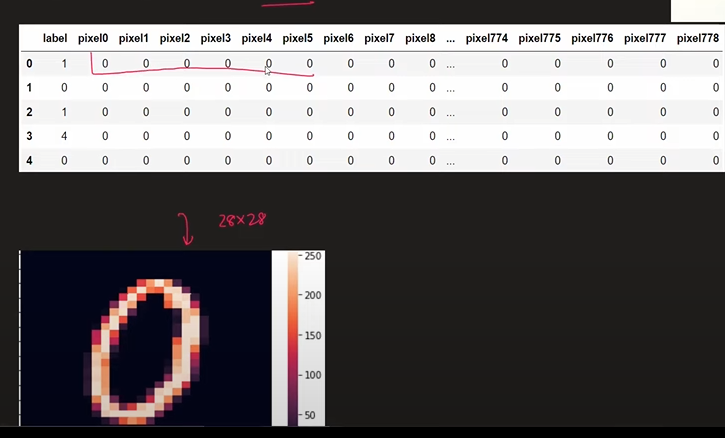

MNIST dataset

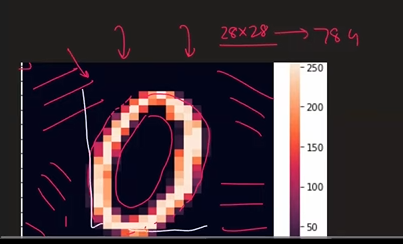

Here, not the entire pixel data is actually useful and thus we could reduce these features and thus improve performance and reduce computational cost

### How feature importance is calculated

In [2]:
from sklearn.datasets import make_classification

In [3]:
from sklearn.tree import DecisionTreeClassifier 

In [4]:
X,y = make_classification(n_samples=5, n_classes=2,
                               n_features=2, n_informative=2, n_redundant=0,
                               random_state=0)

In [5]:
clf = DecisionTreeClassifier()

In [6]:
clf.fit(X,y)

DecisionTreeClassifier()

[Text(0.4, 0.8333333333333334, 'x[1] <= -0.894\ngini = 0.48\nsamples = 5\nvalue = [3, 2]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[0] <= 1.01\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

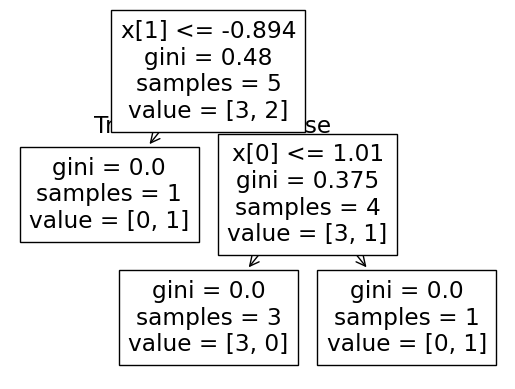

In [7]:
from sklearn.tree import plot_tree
plot_tree(clf)

#### As feature importances are normalized, the importance adds upto 1

In [8]:
clf.feature_importances_

array([0.625, 0.375])

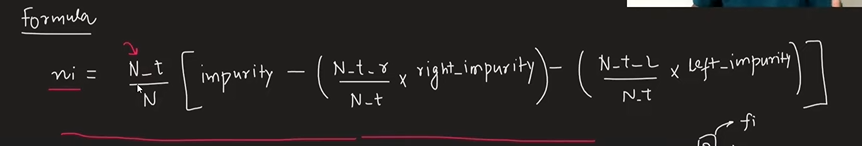

A node's importance calculated using this formula

n_t=no of trees, n_t_r

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=2)
rf.fit(X,y)

RandomForestClassifier(n_estimators=2)

In [10]:
rf.feature_importances_

array([0., 1.])

In [11]:
print(rf.estimators_[0].feature_importances_)
print(rf.estimators_[1].feature_importances_)

print((1 + 0.555)/2)

[0. 0.]
[0. 1.]
0.7775000000000001


In [12]:
X,y = make_classification(n_samples=15, n_classes=2,
                               n_features=2, n_informative=2, n_redundant=0,
                               random_state=0)

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
clf = DecisionTreeClassifier()

In [15]:
clf.fit(X,y)

DecisionTreeClassifier()

[Text(0.3333333333333333, 0.875, 'x[1] <= -0.383\ngini = 0.498\nsamples = 15\nvalue = [8, 7]'),
 Text(0.16666666666666666, 0.625, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.25, 0.75, 'True  '),
 Text(0.5, 0.625, 'x[0] <= 0.878\ngini = 0.346\nsamples = 9\nvalue = [2, 7]'),
 Text(0.41666666666666663, 0.75, '  False'),
 Text(0.3333333333333333, 0.375, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(0.6666666666666666, 0.375, 'x[1] <= -0.278\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.8333333333333334, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]')]

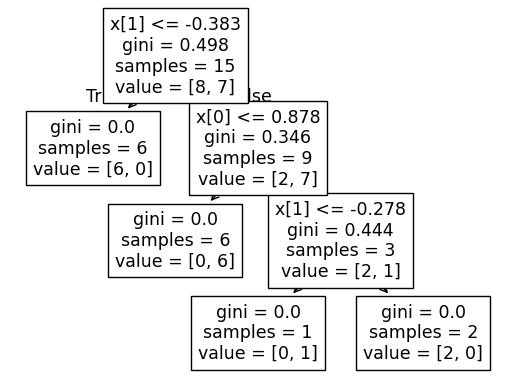

In [16]:
from sklearn.tree import plot_tree
plot_tree(clf)

In [17]:
clf.feature_importances_

array([0.23809524, 0.76190476])